Задание №1 (задача регрессии)
Требуется построить максимально качественную модель прогнозирования РТО торговой точки (поле “opsum 202009”) на основе предоставленных нами данных (по координатам ТТ можно также подтянуть дополнительную информацию из открытых источников), данные до ТТ находятся в папке “data”.
Метрики, по которым нужно производить оптимизацию:
* MAPE. Данную метрику нужно минимизировать.
* Собственная метрика:
1. % точек в зоне перепрогноза РТО. Зона перепрогноза определяется по формуле: РТО/Прогноз РТО < 0,8. Данную зону нужно минимизировать.
2. % точек в зоне недопрогноза РТО. Зона недопрогноза определяется по формуле:
РТО/Прогноз РТО > 1,2. Данную зону нужно минимизировать.
3. % точек в допустимой зоне. Допустимая зона определяется по формуле:
0,8 >= РТО/Прогноз РТО <= 1,2. Данную зону нужно максимизировать.

Требования:
* Требуется добиться MAPE на открытиях 2019г. меньше 26-27%. В идеале ошибка должна быть +- равномерной на всех годах открытия.
* Допустимая зона на открытиях 2019г. должна быть не меньше 50%. В идеале зона должна быть не меньше 50% на всех годах открытия.
* Зона перепрогноза должна быть не больше 20%.


Подключим библиотеки для обработки данных:

In [259]:
import numpy as np
import pandas as pd

Загрузим наш датасет:

In [260]:
# Рабочий вариант
data_origin = pd.read_excel('https://github.com/Golovind121/Project_Magnit/blob/main/data.xlsx?raw=true')

Просмотрим наш датасет

In [261]:
data_origin.head()

,WHS_ID,REGION,Filial,CITY,Площадь ТЗ,Численность семей по Хаффу,Балл Хаффа по частным домам,Численность сотрудников по Хаффу,Количество остановок в окрестности Магазина,Расположение рядом с парком,Наличие больниц в окрестности ТТ,Количество детских садов,Количество отделений банков,Доля балла Хаффа по частным домам,Наличие МК рядом,Количество уникальных маршрутов,"Отрицательный фактор расположения, %",Наличие пешеходного перехода,Численность НП,Расположение на перекрестке,Наличие ВУЗов в радиусе,Интенсивность событий по основным дорогам,Средняя интенсивность событий вне дорог,БЗП,Внутридворовое расположение (от экспертов),Внутриквартальное расположение (от экспертов),На основной улице НП,На междугородней трассe,Расположение на въезде в район (от экспертов),Расположение на дне района (от экспертов),Наличие рынков (от экспертов),Количество авто/жд вокзалов в окрестности торговой точки (от экспертов),Расположение магазина в ТРЦ (от экспертов),Расположение на транспортной развязке,Наличие парковки,Алколицензия,Табачная лицензия,Наличие метро в окрестности Магазина,Экстра-Хафф,Тип расположения\локации,Дата открытия,opsum 202009,latitude,longitude
0,1,Кавказский округ,Камышин,Камышин,697.55690,2237.14502,712.04364,189.52473,0,0,0,0,0,0.528685,0,0,0.000000,1,168711.498,0,0,1.118352,1.188175,34960.8,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,3,199909,2.448182e+07,50.075675,45.399247
1,2,Кавказский округ,Астрахань,Астрахань,884.92090,1909.22780,0.00000,74.29587,2,0,0,0,1,0.000000,1,8,0.000000,0,809259.151,0,0,1.196924,1.222082,36925.1,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,3,200012,2.983678e+07,46.329761,48.049165
2,3,Кавказский округ,Волгоград,Волгоград,745.56137,3298.04834,280.35094,25.26392,1,0,0,0,0,0.136827,0,13,0.000000,1,1533371.148,0,1,0.000000,1.277460,38285.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,3,200012,1.792022e+07,48.617016,44.422526
3,4,Кавказский округ,Волгоград,Волгоград,854.85200,1871.30170,258.35078,115.01732,1,0,0,0,0,0.233865,1,5,0.125917,1,1533371.148,0,0,1.221976,1.219891,38285.0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,3,200101,2.299870e+07,48.647915,44.433414
4,5,Кавказский округ,Волгоград,Волгоград,670.51000,1441.93594,183.48073,0.00000,0,0,0,0,0,0.223610,0,0,0.251833,0,1533371.148,0,0,1.116523,1.143026,38285.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,3,200102,1.135135e+07,48.800492,44.588157


In [262]:
data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 44 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   WHS_ID                                                                   2061 non-null   int64  
 1   REGION                                                                   2061 non-null   object 
 2   Filial                                                                   2061 non-null   object 
 3   CITY                                                                     2061 non-null   object 
 4   Площадь ТЗ                                                               2061 non-null   float64
 5   Численность семей по Хаффу                                               2061 non-null   float64
 6   Балл Хаффа по частным домам                                             

Сделаем копию датасета и выделим колонку таргетов для обучения.

In [263]:
data = data_origin.copy()
target_col = 'opsum 202009'

Перепишем дату чтобы в ней остался только год для будущей проверки и удалим исходную колонку индексов и колонку таргетов. Также выведем количество признаков по годам.

In [264]:
data['Дата открытия'] = (data_origin['Дата открытия'] / 100).astype('int')
data.set_index('Дата открытия', inplace=True)
data.drop(['WHS_ID', 'opsum 202009'], axis=1, inplace=True)
data.index.value_counts()

2017    187
2012    184
2018    182
2011    180
2019    151
2015    147
2013    147
2010    140
2014    131
2016    127
2009     97
2006     73
2008     66
2005     63
2007     55
2004     48
2003     34
2002     27
2001     19
2000      2
1999      1
Name: Дата открытия, dtype: int64

Подключим необходимые библиотеки для визуализации:

In [265]:
from matplotlib import pyplot as plt
import seaborn as sns 

Построим диаграммму корреляции для того чтобы понять какие признаки могут оказать большее влияние на обучение модели. Также увидим какие признаки можно опустить.

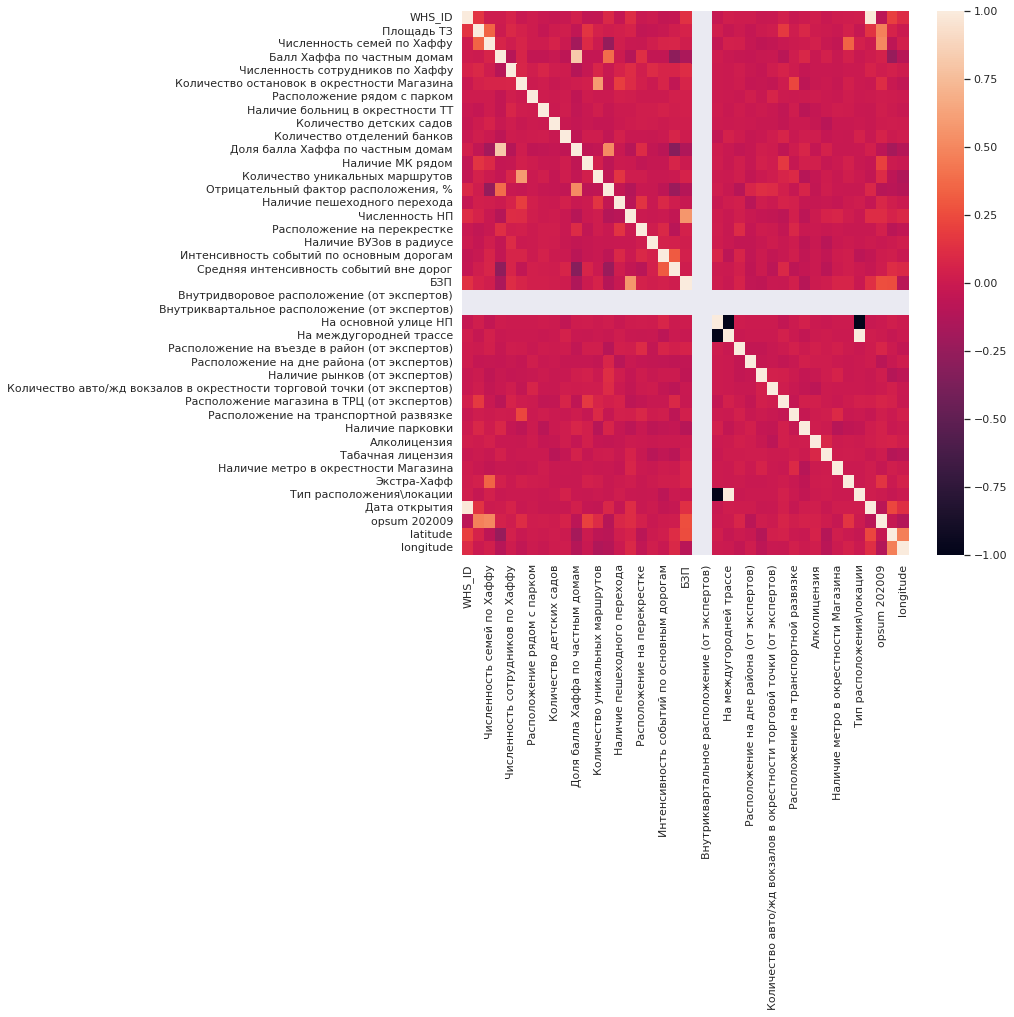

In [266]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_origin.corr())

Данные с колонок 'Внутридворовое расположение (от экспертов)',
 'Внутриквартальное расположение (от экспертов)' никак не коррелируют с другими данными. Каких-то конкретных колонок призников которые сильно бы имели сильную связь с колонкой таргетов не обнаружено.

Найдем колонки признаков в которых имеются одинаковые значения:

In [267]:
one_num_columns = []
for col in data_origin.columns:
    if data_origin[col].min() == data_origin[col].max():
        one_num_columns.append(col)
one_num_columns

['Внутридворовое расположение (от экспертов)',
 'Внутриквартальное расположение (от экспертов)']

Отбросим выделеные колонки.

In [268]:
data.drop(one_num_columns, axis=1, inplace=True)

# Проанализируем все колоки признаков

In [269]:
for i in ['REGION', 'Filial', 'CITY']:
    print(data_origin[i].value_counts(),'\n')

Волжский округ          502
Камский округ           486
Южно-Уральский округ    432
Кавказский округ        336
Черноземный округ       305
Name: REGION, dtype: int64 

Саратов             134
Челябинск           132
Казань              110
Волгоград           108
Самара              100
Воронеж              99
Чебоксары            99
Уфа                  94
Тольятти             88
Набережные Челны     86
Ульяновск            80
Белгород             78
Оренбург             77
Пенза                76
Ижевск               74
Астрахань            67
Ставрополь           64
Киров                63
Стерлитамак          56
Сыктывкар            54
Липецк               53
Пятигорск            49
Тамбов               44
Прохладный           35
Рязань               31
Магнитогорск         29
Саранск              24
Курган               22
Орск                 22
Камышин              13
Name: Filial, dtype: int64 

Казань        95
Самара        88
Саратов       87
Волгоград     85
Челябинск     

In [270]:
float_cols = list()
for col in data.columns:
    if data[col].dtypes == float:
        float_cols.append(col)
        print(data[col].describe(), '\n')

count    2061.000000
mean      711.410277
std       154.380231
min       374.051800
25%       594.355600
50%       703.510240
75%       807.557700
max      1747.263710
Name: Площадь ТЗ, dtype: float64 

count    2061.000000
mean     1474.670739
std       716.972342
min       222.936690
25%       969.763550
50%      1347.906410
75%      1843.831720
max      6859.052260
Name: Численность семей по Хаффу, dtype: float64 

count    2061.000000
mean       88.136469
std       189.192140
min         0.000000
25%         0.000000
50%         2.311830
75%        80.052780
max      1597.081670
Name: Балл Хаффа по частным домам, dtype: float64 

count    2061.000000
mean      173.157631
std       334.972762
min         0.000000
25%        22.665000
50%        77.786280
75%       192.637390
max      8623.730300
Name: Численность сотрудников по Хаффу, dtype: float64 

count    2061.000000
mean        0.137493
std         0.314915
min         0.000000
25%         0.000000
50%         0.002787
75%    

In [271]:
int_cols = list()
for col in data.columns:
    if data[col].dtypes == int:
        int_cols.append(col)
        print(data[col].describe(), '\n')

count    2061.000000
mean        0.574478
std         0.882356
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         4.000000
Name: Количество остановок в окрестности Магазина, dtype: float64 

count    2061.000000
mean        0.040757
std         0.197775
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Расположение рядом с парком, dtype: float64 

count    2061.000000
mean        0.108685
std         0.311319
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Наличие больниц в окрестности ТТ, dtype: float64 

count    2061.000000
mean        0.041242
std         0.208432
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Количество детских садов, dtype: float64 

count    2061.000000
mean        0.069384
std         0.256070
min         0.000000
25%         0.0000

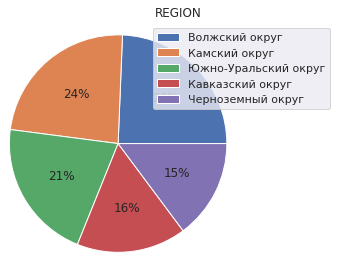

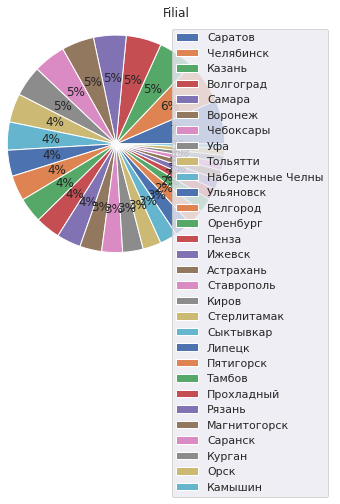

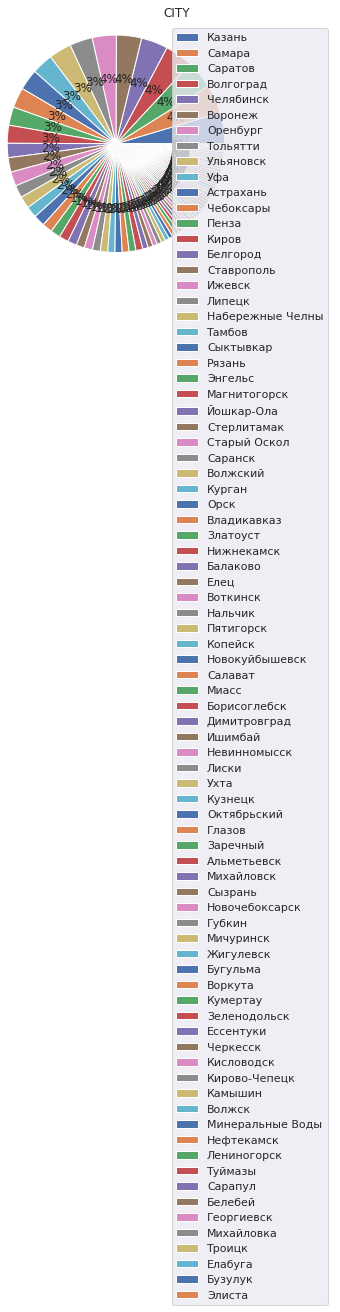

In [272]:
n = 1
for i in cat_col:
    vc = data[i].value_counts()
    fig, ax = plt.subplots()
    ax.pie(vc, radius=4.5, center=(4, 4), autopct='%1.0f%%',
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=False)
    ax.set(xlim=(0, 13), ylim=(0, 9))
    plt.title(i)
    ax.legend(vc.index)
    plt.show()

# Предобработка числовых и категориальных данных

Произведем нормирование числовых данных

In [273]:
from sklearn.preprocessing import StandardScaler

data_num_col_norm = StandardScaler().fit_transform(data[float_cols]) 

Произведем кодирование категориальных данных

In [274]:
cat_col = ['REGION', 'Filial', 'CITY']
data_cat_col = pd.get_dummies(data_origin[cat_col], drop_first=True)

Объединим данные


In [275]:
X = pd.DataFrame(data_num_col_norm, columns=float_cols).join(data_cat_col)
X = X.join(data_origin[int_cols])

Сформированный массив имеет размерность исходных данных (2061)

In [276]:
X.shape

(2061, 150)

Заменим индексы на значения даты открытия:

In [277]:
X.set_index(data.index, inplace=True)

Сформируем массив таргетов и также заменим в нем индексы на значения даты открытия:

In [278]:
y = data_origin[target_col].copy()
y.set_axis(data.index, inplace=True)

# Обучение моделей из sklearn (LinearRegression, SGDRegression)

In [279]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

Выведем количество данных за 2019 год которые находятся в тестовой выборке:

In [281]:
y_test.loc[2019].count()

30

Реализуем собственную метрику

In [282]:
def My_metric(target, pred):
    Percent_overpredict = 1 / len(target) * np.sum(target / pred)
    return Percent_overpredict

Реализуем модель линейной регрессии и обучим ее:

In [283]:
model_LR = LinearRegression()

model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_val = model_LR.predict(X_val)

score_train = mean_absolute_percentage_error(y_pred_train, y_train)
score_val = mean_absolute_percentage_error(y_val, y_pred_val)

print('MAPE train: ', score_train)
print('MAPE val', score_val)

MAPE train:  0.19180653605965448
MAPE val 0.21049689343839253


Получим предсказания на 2019 год

In [284]:
y_pred_2019 = model_LR.predict(X_2019)

score_2019 = mean_absolute_percentage_error(y_2019, y_pred_2019)

print('2019: ', score_2019)

2019:  0.2971925743156305


Реализуем модель регрессии с помощью стохастического градиентного спуска и обучим ее:

In [285]:
model_SGD = SGDRegressor()

model_SGD.fit(X_train, y_train)

y_pred_train = model_SGD.predict(X_train)
y_pred_val = model_SGD.predict(X_val)

score_train = mean_absolute_percentage_error(y_train, y_pred_train)
score_val = mean_absolute_percentage_error(y_val, y_pred_val)

print('MAPE train: ', score_train)
print('MAPE val', score_val)

MAPE train:  0.20782856502249897
MAPE val 0.2097528737007695


Сделаем прогнзо на 2019 год:

In [286]:
y_pred_2019 = model_SGD.predict(X_2019)

score_2019 = mean_absolute_percentage_error(y_2019, y_pred_2019)
my_sc1 = My_metric(y_2019, y_pred_2019)

print('2019:', score_2019)

2019: 0.3072139308635748


Используем поиск по сетке параметров для достижение лучшего качества модели:

In [287]:
params = {'max_iter':[1000, 1500, 2000],
          'loss':['squared_error', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive']
          }
grid_search = GridSearchCV(model_SGD, params, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linea

{'loss': 'squared_error', 'max_iter': 2000}


In [288]:
model_SGD = SGDRegressor(loss='squared_epsilon_insensitive', max_iter=1500)

model_SGD.fit(X_train, y_train)

y_pred_train = model_SGD.predict(X_train)
y_pred_val = model_SGD.predict(X_val)

score_train = mean_absolute_percentage_error(y_train, y_pred_train)
score_val = mean_absolute_percentage_error(y_val, y_pred_val)

print('MAPE train: ', score_train)
print('MAPE val', score_val)

MAPE train:  0.2282734784661012
MAPE val 0.23423765410076988


In [289]:
y_pred_2019 = model_SGD.predict(X_2019)

score_2019 = mean_absolute_percentage_error(y_2019, y_pred_2019)
my_sc1 = My_metric(y_2019, y_pred_2019)

print('2019:', score_2019)
print('Собственная метрика(2019): 1.2 <', my_sc1, '< 0.8')

2019: 0.34672476659995205
Собственная метрика(2019): 1.2 < 0.815806837316926 < 0.8


На данном этапе можно сказать что задача является решенной. Попробуем использовать алгоритм градиентного бустинга из библиотеки CatBoost для получения лучшего качества.

# Использование градиентного бустинга из библиотеки CatBoost

In [290]:
pip install catboost

In [291]:
import catboost

Обучим модель и выведем предсказания

In [292]:
model_catboost = catboost.CatBoostRegressor(random_seed=42, iterations=100, verbose=10, eval_metric='MAPE')

model_catboost.fit(X_train, y_train)

y_pred_train = model_catboost.predict(X_train)
y_pred_test = model_catboost.predict(X_test)

score_train = mean_absolute_percentage_error(y_pred_train, y_train)
score_test = mean_absolute_percentage_error(y_pred_test, y_test)

print('MAPE train: ', score_train)
print('MAPE test', score_test)

Learning rate set to 0.288044
0:	learn: 0.2956664	total: 4.7ms	remaining: 466ms
10:	learn: 0.2153768	total: 46.4ms	remaining: 375ms
20:	learn: 0.1983236	total: 103ms	remaining: 387ms
30:	learn: 0.1924321	total: 138ms	remaining: 308ms
40:	learn: 0.1829385	total: 181ms	remaining: 260ms
50:	learn: 0.1724590	total: 227ms	remaining: 218ms
60:	learn: 0.1652785	total: 271ms	remaining: 173ms
70:	learn: 0.1566421	total: 324ms	remaining: 132ms
80:	learn: 0.1476707	total: 365ms	remaining: 85.6ms
90:	learn: 0.1409984	total: 414ms	remaining: 41ms
99:	learn: 0.1353749	total: 458ms	remaining: 0us
MAPE train:  0.12608926071440063
MAPE test 0.21162340769276683


Сделаем прогнзоз на 2019 год:

In [293]:
y_pred_2019 = model_catboost.predict(X_2019.loc[2019])
score_2019 = mean_absolute_percentage_error(y_2019.loc[2019], y_pred_2019)
print('2019: ', score_2019)

2019:  0.21528277651540795


Используем поиск по сетке параметров для достижение лучшего качества модели:

In [294]:
model = catboost.CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1, 1e-3],
        'depth': [4, 6, 10],
        'iterations': [30, 50, 80, 100]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train)
grid_search_result

0:	learn: 10443557.5941625	test: 10390339.8000293	best: 10390339.8000293 (0)	total: 2.07ms	remaining: 60ms
1:	learn: 10174179.2568773	test: 10121632.5921132	best: 10121632.5921132 (1)	total: 3.89ms	remaining: 54.5ms
2:	learn: 9914734.2352939	test: 9865180.3895154	best: 9865180.3895154 (2)	total: 5.67ms	remaining: 51ms
3:	learn: 9664311.4349964	test: 9617512.5647723	best: 9617512.5647723 (3)	total: 7.48ms	remaining: 48.6ms
4:	learn: 9417745.8511825	test: 9372969.2966310	best: 9372969.2966310 (4)	total: 9.26ms	remaining: 46.3ms
5:	learn: 9180419.5002168	test: 9133179.7142605	best: 9133179.7142605 (5)	total: 11ms	remaining: 44.1ms
6:	learn: 8949770.0811495	test: 8896450.1932412	best: 8896450.1932412 (6)	total: 13.2ms	remaining: 43.4ms
7:	learn: 8728263.8581976	test: 8669805.9795899	best: 8669805.9795899 (7)	total: 15.3ms	remaining: 42.1ms
8:	learn: 8512298.6170474	test: 8457313.4574014	best: 8457313.4574014 (8)	total: 17.4ms	remaining: 40.6ms
9:	learn: 8304911.9758904	test: 8254649.829462

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

Подставим параметры в модель и посмотрим результат предсказания

In [295]:
model_catboost = catboost.CatBoostRegressor(random_seed=42, depth=6, learning_rate=0.1,  verbose=100, eval_metric='MAPE')

model_catboost.fit(X_train, y_train)  

y_pred_train_CB = model_catboost.predict(X_train)
y_pred_val_CB = model_catboost.predict(X_val)

score_train_CB = mean_absolute_percentage_error(y_pred_train_CB, y_train_CB)
score_val_CB = mean_absolute_percentage_error(y_pred_val_CB, y_val_CB)

print('MAPE train: ', score_train_CB)
print('MAPE val', score_val_CB)

0:	learn: 0.3111071	total: 5.63ms	remaining: 5.63s
100:	learn: 0.1874153	total: 433ms	remaining: 3.85s
200:	learn: 0.1577855	total: 873ms	remaining: 3.47s
300:	learn: 0.1337750	total: 1.3s	remaining: 3.03s
400:	learn: 0.1141167	total: 1.75s	remaining: 2.61s
500:	learn: 0.1002460	total: 2.17s	remaining: 2.16s
600:	learn: 0.0884072	total: 2.6s	remaining: 1.73s
700:	learn: 0.0779056	total: 3.02s	remaining: 1.29s
800:	learn: 0.0691811	total: 3.44s	remaining: 855ms
900:	learn: 0.0606527	total: 3.87s	remaining: 426ms
999:	learn: 0.0535409	total: 4.29s	remaining: 0us
MAPE train:  0.05143681987043056
MAPE val 0.21233679245700537


In [296]:
y_pred_2019_CB = model_catboost.predict(X_2019.loc[2019])
score_2019_CB = mean_absolute_percentage_error(y_2019.loc[2019], y_pred_2019_CB)
my_sc1 = My_metric(y_2019, y_pred_2019)

print('2019: ', score_2019_CB)
print('Собственная метрика(2019): 1.2 <', my_sc1, '< 0.8')

2019:  0.11625639108063927
Собственная метрика(2019): 1.2 < 0.8861341883607742 < 0.8


Попробуем дополнительно увеличить число итераций:

In [297]:
model_catboost = catboost.CatBoostRegressor(random_seed=42, depth=6, iterations=10000, learning_rate=0.1,  verbose=1000, eval_metric='MAPE')

model_catboost.fit(X_train, y_train)  

y_pred_train = model_catboost.predict(X_train)
y_pred_test = model_catboost.predict(X_test)

score_train= mean_absolute_percentage_error(y_pred_train, y_train)
score_test = mean_absolute_percentage_error(y_pred_test, y_test)

print('MAPE train: ', score_train_CB)
print('MAPE val', score_val_CB)

0:	learn: 0.3111071	total: 6.93ms	remaining: 1m 9s
1000:	learn: 0.0535368	total: 4.18s	remaining: 37.6s
2000:	learn: 0.0173030	total: 8.27s	remaining: 33.1s
3000:	learn: 0.0062984	total: 12.4s	remaining: 28.8s
4000:	learn: 0.0023263	total: 16.5s	remaining: 24.8s
5000:	learn: 0.0009135	total: 20.6s	remaining: 20.6s
6000:	learn: 0.0003793	total: 24.7s	remaining: 16.5s
7000:	learn: 0.0001666	total: 28.8s	remaining: 12.4s
8000:	learn: 0.0000718	total: 33.1s	remaining: 8.27s
9000:	learn: 0.0000317	total: 37.2s	remaining: 4.13s
9999:	learn: 0.0000137	total: 41.3s	remaining: 0us
MAPE train:  0.05143681987043056
MAPE val 0.21233679245700537


In [298]:
y_pred_2019_CB = model_catboost.predict(X_2019.loc[2019])
score_2019_CB = mean_absolute_percentage_error(y_2019.loc[2019], y_pred_2019_CB)
my_sc1 = My_metrics(y_2019, y_pred_2019)


print('2019: ', score_2019_CB)
print('Percent_overpredict: 1.2 <', my_sc1, '< 0.8')

2019:  0.055515484943577255
Percent_overpredict: 1.2 < 0.8861341883607742 < 0.8


Сформируем словарь со значениями метрик по годам:

In [303]:
year_loss = {}
for ind in data.index.unique():
    try:
        pred = model_catboost.predict(X.loc[ind])
        loss = mean_absolute_percentage_error(y.loc[ind], pred)
        my_loss = My_metrics(y.loc[ind], pred)
        year_loss[ind] = [loss, my_loss]
    except:
        print(ind)

1999


Сформируем массивы данных со словаря для того чтобы вывести их на график. Также выведем полученный словарь с результатами по годам:

In [304]:
MAPE_list = list()
My_metric_list = list()
year_list = list()
for year, loss in year_loss.items():
    MAPE_list.append(loss[0])
    My_metric_list.append(loss[1])
    year_list.append(year)
    print(year, loss)

2000 [2.587129715031079e-06, 1.0000025871382805]
2001 [7.866718360869776e-06, 1.0000048725555906]
2002 [0.05520426986389228, 1.0195971681277944]
2003 [0.0677552035182897, 1.0237441131321365]
2004 [0.05630387319951107, 1.057571407803584]
2005 [0.014620442361878577, 1.000196842808968]
2006 [0.029749448982749435, 1.012790903292263]
2007 [0.051578917082548144, 0.9951236844960378]
2008 [0.05657094664470706, 1.0459799570902586]
2009 [0.04025565233349316, 1.0206572962206029]
2010 [0.0662902964328198, 1.0063986911415965]
2011 [0.031409721314735725, 0.9857204558402929]
2012 [0.043730560780741945, 0.999359265464444]
2013 [0.032471903257557444, 1.006300041307118]
2014 [0.0436194557099342, 0.9902526016636655]
2015 [0.05141430348838045, 0.997264113597446]
2016 [0.04895855119869376, 0.9935734905480124]
2017 [0.050873570654977184, 1.0050883682852265]
2018 [0.04156379129099816, 1.000549107981723]
2019 [0.055515484943577255, 0.9708684529199212]


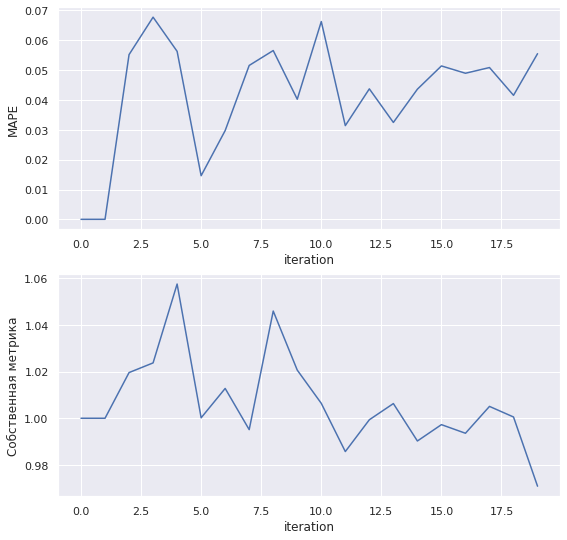

In [316]:
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.plot(np.arange(len(MAPE_list)), MAPE_list);
plt.ylabel('MAPE');plt.xlabel('iteration')
plt.subplot(2,1,2)
plt.plot(np.arange(len(My_metric_list)), My_metric_list);
plt.ylabel('Собственная метрика');plt.xlabel('iteration')
plt.show()

По данным с графика видно что значение МАРЕ на всех годах не превышает 0,26 и данные собственной метрики находятся между диапазонами 0,8 и 1,2.